###Install Mediapipe

In [1]:
%%capture
!pip install mediapipe

### Import Libraries

In [2]:
import numpy as np
import os,cv2,math,glob,random
import scipy.io as sio
from math import cos, sin
from pathlib import Path
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import mediapipe as mp
from scipy.io import loadmat

# Model Libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
warnings.filterwarnings('ignore')



### Unzip the Images Dataset

In [3]:
%%capture
if os.path.isdir('/content/AFLW2000-3D.zip') == False:
  !unzip /content/AFLW2000-3D.zip

### Data Extraction and Normalization

In [4]:
# dictionary and lists to store the extraced data from files
images_dict = {}
pitch = []
yaw = []
roll = []

# Specifying the folder path that contains raw data
images_folder = r'/content/AFLW2000'

# Initializing the face mesh module
faceModule = mp.solutions.face_mesh

# Loading image and its corresponding mat file
for i in range(2, 4376):

    # Constructing file path for image file and matlab file
    image_path = os.path.join(images_folder, f'image{i:05d}.jpg')
    mat_path = os.path.join(images_folder, f'image{i:05d}.mat')

    with faceModule.FaceMesh(static_image_mode=True) as faces:
        # Loading the image
        image = cv2.imread(image_path)

        try:
            # Processing the face to extract the landmark points (468 points) for each x, y
            results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

            # Checking if there are multiple face landmarks detected
            if results.multi_face_landmarks:
                nose_landmark = results.multi_face_landmarks[0].landmark[4]
                chin_landmark = results.multi_face_landmarks[0].landmark[152]
                face_shape = np.sqrt((nose_landmark.x - chin_landmark.x)**2 + (nose_landmark.y - chin_landmark.y)**2)
                 # Index 4 corresponds to the NoseTip landmark


                # Looping over the faces in the image
                image_landmarks = {}
                id = 0

                for face in results.multi_face_landmarks:
                    for landmark in face.landmark:
                        x = (landmark.x - nose_landmark.x)/face_shape
                        y = (landmark.y - nose_landmark.y)/face_shape

                        # Convert relative coordinates to absolute coordinates
                        height, width, _ = image.shape
                        relative_x = int(x * width)
                        relative_y = int(y * height)

                        # Save landmarks to dictionary
                        image_landmarks[f'x{id}'] = x
                        image_landmarks[f'y{id}'] = y
                        id += 1

                        # Visualization: Draw circles on landmarks
                        cv2.circle(image, (relative_x, relative_y), radius=1, color=(0, 255, 0), thickness=2)

                # Save landmarks dictionary for the current image
                images_dict[f'image{i:05d}'] = image_landmarks

                # loading the mat file to extract the labels (pitch,yaw,roll)
                mat_data = loadmat(mat_path)

                # Extract pose parameters from MATLAB data
                pose_para = mat_data["Pose_Para"][0][:3]
                pitch.append(pose_para[0])
                yaw.append(pose_para[1])
                roll.append(pose_para[2])

        except Exception as e:
            # Handle exceptions during processing
            # print(f"Error processing image {i}: {str(e)}")
            pass


In [5]:
features = pd.DataFrame.from_dict(images_dict, orient='index')
features

,x0,y0,x1,y1,x2,y2,x3,y3,x4,y4,...,x463,y463,x464,y464,x465,y465,x466,y466,x467,y467
image00002,-0.023766,0.318033,-0.006607,0.089623,-0.003661,0.126111,-0.052436,-0.284171,0.0,0.0,...,0.334869,-0.658936,0.280270,-0.621764,0.246334,-0.585163,0.847951,-0.725764,0.898419,-0.761263
image00004,0.135390,0.342489,0.007973,0.080386,0.173977,0.176596,0.106425,-0.167740,0.0,0.0,...,0.561180,-0.368172,0.502940,-0.343096,0.446485,-0.326326,0.887145,-0.403468,0.937679,-0.429012
image00006,-0.034451,0.295173,-0.001236,0.081678,-0.029573,0.134064,-0.097803,-0.205510,0.0,0.0,...,0.121871,-0.470623,0.083497,-0.441704,0.067555,-0.418426,0.488717,-0.515062,0.528595,-0.545855
image00008,0.206938,0.278244,0.038110,0.079997,0.136178,0.103737,-0.085015,-0.232270,0.0,0.0,...,0.224828,-0.670657,0.176554,-0.623308,0.141488,-0.583820,0.656938,-0.893207,0.691559,-0.947129
image00013,0.088346,0.338087,0.018155,0.080560,0.046324,0.159416,-0.083512,-0.169726,0.0,0.0,...,0.129485,-0.412059,0.090370,-0.385039,0.070019,-0.368888,0.458136,-0.529165,0.493518,-0.545693
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
image04345,-0.099509,0.382300,-0.012532,0.091444,-0.082647,0.161951,-0.118476,-0.237458,0.0,0.0,...,0.069188,-0.551927,0.032662,-0.521384,0.023654,-0.495524,0.468628,-0.638928,0.502156,-0.664404
image04348,-0.114418,0.343310,-0.014925,0.089406,-0.089373,0.143153,-0.106608,-0.248062,0.0,0.0,...,0.063322,-0.572256,0.034897,-0.538985,0.030157,-0.510105,0.424913,-0.634097,0.461928,-0.675651
image04356,-0.100844,0.302607,-0.022521,0.075017,-0.068619,0.153835,-0.028862,-0.183603,0.0,0.0,...,0.235679,-0.317604,0.193756,-0.308145,0.170728,-0.299684,0.540394,-0.272573,0.580638,-0.305275
image04358,-0.056898,0.364123,-0.013462,0.097607,-0.029582,0.156435,-0.064382,-0.279807,0.0,0.0,...,0.324614,-0.612608,0.261693,-0.582368,0.225926,-0.553400,0.822239,-0.653323,0.873485,-0.689914


In [6]:
labels = pd.DataFrame({'Yaw': yaw, 'Pitch': pitch, 'Roll': roll})
labels

,Yaw,Pitch,Roll
0,0.018227,-0.399231,0.085676
1,1.189533,0.470065,0.300959
2,0.881137,-0.184650,-0.236852
3,0.299208,-0.175379,-0.373374
4,0.011965,-0.026812,-0.220662
...,...,...,...
1848,-0.283822,-0.306358,0.038554
1849,-0.429723,-0.367547,0.122791
1850,0.567114,-0.156035,-0.108536
1851,-0.070430,-0.197102,0.105118


### Saving Data to CSV Files

In [7]:
features.to_csv("features.csv", index=False)

In [8]:
labels.to_csv("labels.csv", index=False)

### Splitting Data

In [9]:
features_train, features_validation_test, labels_train, labels_validation_test = train_test_split(features, labels, test_size=0.2,random_state=200)
features_validation, features_test, labels_validation, labels_test = train_test_split(features_validation_test, labels_validation_test, test_size=0.5,random_state=200)


### Training different models on our dataset

We'll train three models:
- Xgboost regressor
- Random forest regressor
- support vector regrssor



#### Xgboost Regressor

In [10]:
# Model for Yaw
model_yaw_xg = xgb.XGBRegressor( random_state=0,verbosity=0)
model_yaw_xg.fit(features_train, labels_train['Yaw'])
print('R2 score for yaw (validation):',model_yaw_xg.score(features_validation,labels_validation['Yaw']))

# Model for Pitch
model_pitch_xg = xgb.XGBRegressor( random_state=0,verbosity=0)
model_pitch_xg.fit(features_train, labels_train['Pitch'])
print('R2 score for pitch (validation):',model_pitch_xg.score(features_validation,labels_validation['Pitch']))

# Model for Roll
model_roll_xg = xgb.XGBRegressor(random_state=0,verbosity=0)
model_roll_xg.fit(features_train, labels_train['Roll'])
print('R2 score for roll (validation):',model_roll_xg.score(features_validation,labels_validation['Roll']))


R2 score for yaw (validation): 0.888210128652656
R2 score for pitch (validation): 0.8096378951658829
R2 score for roll (validation): 0.8801065702550023


Calculate MSE for training and validation sets




In [11]:
# Make predictions on the Training set
predictions_yaw = model_yaw_xg.predict(features_train)
predictions_pitch = model_pitch_xg.predict(features_train)
predictions_roll = model_roll_xg.predict(features_train)

# Calculate mean squared error for each target variable
mse_yaw = mean_squared_error(labels_train['Yaw'], predictions_yaw)
mse_pitch = mean_squared_error(labels_train['Pitch'], predictions_pitch)
mse_roll = mean_squared_error(labels_train['Roll'], predictions_roll)

# Print MSE for each target variable
print("Mean Squared Error for Yaw (Train): ", mse_yaw)
print("Mean Squared Error for Pitch (Train): ", mse_pitch)
print("Mean Squared Error for Roll (Train): ", mse_roll)

Mean Squared Error for Yaw (Train):  6.136142026135902e-06
Mean Squared Error for Pitch (Train):  1.6719488416458963e-05
Mean Squared Error for Roll (Train):  3.902694216682426e-06


In [12]:
# Make predictions on the validation set
predictions_yaw = model_yaw_xg.predict(features_validation)
predictions_pitch = model_pitch_xg.predict(features_validation)
predictions_roll = model_roll_xg.predict(features_validation)

# Calculate mean squared error for each target variable
mse_yaw = mean_squared_error(labels_validation['Yaw'], predictions_yaw)
mse_pitch = mean_squared_error(labels_validation['Pitch'], predictions_pitch)
mse_roll = mean_squared_error(labels_validation['Roll'], predictions_roll)

# Print MSE for each target variable
print("Mean Squared Error for Yaw (Validation): ", mse_yaw)
print("Mean Squared Error for Pitch (Validation): ", mse_pitch)
print("Mean Squared Error for Roll (Validation): ", mse_roll)

Mean Squared Error for Yaw (Validation):  0.027315098698340784
Mean Squared Error for Pitch (Validation):  0.010640619387142192
Mean Squared Error for Roll (Validation):  0.010035143490184629


#### Random Forest Regressor

In [13]:
# Model for Yaw
model_yaw_rf = RandomForestRegressor(random_state=0)
model_yaw_rf.fit(features_train, labels_train['Yaw'])
print('R2 score for yaw (validation):', model_yaw_rf.score(features_validation, labels_validation['Yaw']))

# Model for Pitch
model_pitch_rf = RandomForestRegressor(random_state=0)
model_pitch_rf.fit(features_train, labels_train['Pitch'])
print('R2 score for pitch (validation):', model_pitch_rf.score(features_validation, labels_validation['Pitch']))

# Model for Roll
model_roll_rf = RandomForestRegressor(random_state=0)
model_roll_rf.fit(features_train, labels_train['Roll'])
print('R2 score for roll (validation):', model_roll_rf.score(features_validation, labels_validation['Roll']))


R2 score for yaw (validation): 0.9474599823233107
R2 score for pitch (validation): 0.7630282492992815
R2 score for roll (validation): 0.5325861470820159


Calculate MSE for training and validation sets

In [14]:
# Make predictions on the Training set
predictions_yaw = model_yaw_rf.predict(features_train)
predictions_pitch = model_pitch_rf.predict(features_train)
predictions_roll = model_roll_rf.predict(features_train)

# Calculate mean squared error for each target variable
mse_yaw = mean_squared_error(labels_train['Yaw'], predictions_yaw)
mse_pitch = mean_squared_error(labels_train['Pitch'], predictions_pitch)
mse_roll = mean_squared_error(labels_train['Roll'], predictions_roll)

# Print MSE for each target variable
print("Mean Squared Error for Yaw (Train): ", mse_yaw)
print("Mean Squared Error for Pitch (Train): ", mse_pitch)
print("Mean Squared Error for Roll (Train): ", mse_roll)

Mean Squared Error for Yaw (Train):  0.010298008916196222
Mean Squared Error for Pitch (Train):  0.08449829768347475
Mean Squared Error for Roll (Train):  0.07302287432204989


In [15]:
# Make predictions on the validation set
predictions_yaw = model_yaw_rf.predict(features_validation)
predictions_pitch = model_pitch_rf.predict(features_validation)
predictions_roll = model_roll_rf.predict(features_validation)

# Calculate mean squared error for each target variable
mse_yaw = mean_squared_error(labels_validation['Yaw'], predictions_yaw)
mse_pitch = mean_squared_error(labels_validation['Pitch'], predictions_pitch)
mse_roll = mean_squared_error(labels_validation['Roll'], predictions_roll)

# Print MSE for each target variable
print("Mean Squared Error for Yaw (Validation): ", mse_yaw)
print("Mean Squared Error for Pitch (Validation): ", mse_pitch)
print("Mean Squared Error for Roll (Validation): ", mse_roll)

Mean Squared Error for Yaw (Validation):  0.012837797835836185
Mean Squared Error for Pitch (Validation):  0.01324594622920549
Mean Squared Error for Roll (Validation):  0.039122786739093404


#### Support Vector Regressor

In [16]:
# Model for Yaw
model_yaw_svr = SVR()
model_yaw_svr.fit(features_train, labels_train['Yaw'])
print('R2 score for yaw (validation):',model_yaw_svr.score(features_validation,labels_validation['Yaw']))

# Model for Pitch
model_pitch_svr = SVR()
model_pitch_svr.fit(features_train,labels_train['Pitch'])
print('R2 score for pitch (validation):',model_pitch_svr.score(features_validation,labels_validation['Pitch']))

# Model for Roll
model_roll_svr = SVR()
model_roll_svr.fit(features_train, labels_train['Roll'])
print('R2 score for roll (validation):',model_roll_svr.score(features_validation,labels_validation['Roll']))

R2 score for yaw (validation): 0.9603892137586089
R2 score for pitch (validation): 0.8478089189988904
R2 score for roll (validation): 0.9320622768140102


Calculate MSE for training and validation sets

In [17]:
# Make predictions on the Training set
predictions_yaw = model_yaw_svr.predict(features_train)
predictions_pitch = model_pitch_svr.predict(features_train)
predictions_roll = model_roll_svr.predict(features_train)

# Calculate mean squared error for each target variable
mse_yaw = mean_squared_error(labels_train['Yaw'], predictions_yaw)
mse_pitch = mean_squared_error(labels_train['Pitch'], predictions_pitch)
mse_roll = mean_squared_error(labels_train['Roll'], predictions_roll)

# Print MSE for each target variable
print("Mean Squared Error for Yaw (Train): ", mse_yaw)
print("Mean Squared Error for Pitch (Train): ", mse_pitch)
print("Mean Squared Error for Roll (Train): ", mse_roll)

Mean Squared Error for Yaw (Train):  0.049604231082487016
Mean Squared Error for Pitch (Train):  0.29173228538880336
Mean Squared Error for Roll (Train):  0.3489189178961339


In [18]:
# Make predictions on the validation set
predictions_yaw = model_yaw_svr.predict(features_validation)
predictions_pitch = model_pitch_svr.predict(features_validation)
predictions_roll = model_roll_svr.predict(features_validation)

# Calculate mean squared error for each target variable
mse_yaw = mean_squared_error(labels_validation['Yaw'], predictions_yaw)
mse_pitch = mean_squared_error(labels_validation['Pitch'], predictions_pitch)
mse_roll = mean_squared_error(labels_validation['Roll'], predictions_roll)

# Print MSE for each target variable
print("Mean Squared Error for Yaw (Validation): ", mse_yaw)
print("Mean Squared Error for Pitch (Validation): ", mse_pitch)
print("Mean Squared Error for Roll (Validation): ", mse_roll)

Mean Squared Error for Yaw (Validation):  0.009678627613235772
Mean Squared Error for Pitch (Validation):  0.008506983931816146
Mean Squared Error for Roll (Validation):  0.0056864233679685535


#### Gridsearch for SVR

In [19]:

# Create the SVR models for Yaw, Pitch, and Roll
model_yaw = SVR()
model_pitch = SVR()
model_roll = SVR()

# Define the parameter grid to search with a wider range
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'epsilon': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

# Create GridSearchCV objects for Yaw, Pitch, and Roll
grid_search_yaw = GridSearchCV(estimator=model_yaw, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search_pitch = GridSearchCV(estimator=model_pitch, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search_roll = GridSearchCV(estimator=model_roll, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)

# Perform grid search for Yaw
grid_search_yaw.fit(features_train, labels_train['Yaw'])
print("Best Parameters for Yaw: ", grid_search_yaw.best_params_)
print("Best MSE for Yaw: ", -grid_search_yaw.best_score_)

# Perform grid search for Pitch
grid_search_pitch.fit(features_train, labels_train['Pitch'])
print("Best Parameters for Pitch: ", grid_search_pitch.best_params_)
print("Best MSE for Pitch: ", -grid_search_pitch.best_score_)

# Perform grid search for Roll
grid_search_roll.fit(features_train, labels_train['Roll'])
print("Best Parameters for Roll: ", grid_search_roll.best_params_)
print("Best MSE for Roll: ", -grid_search_roll.best_score_)

Best Parameters for Yaw:  {'C': 1, 'epsilon': 0.001}
Best MSE for Yaw:  0.053773800546548234
Best Parameters for Pitch:  {'C': 1, 'epsilon': 0.001}
Best MSE for Pitch:  0.2978554497608397
Best Parameters for Roll:  {'C': 100, 'epsilon': 0.01}
Best MSE for Roll:  0.3449254033974221


### Choosing SVR for our problem

In [20]:
# Model for Yaw
model_yaw_svr = SVR(C=10,gamma=0.001)
model_yaw_svr.fit(features_train, labels_train['Yaw'])
print('R2 score for yaw (validation):',model_yaw_svr.score(features_validation,labels_validation['Yaw']))

# Model for Pitch
model_pitch_svr = SVR(C=12,gamma=0.01)
model_pitch_svr.fit(features_train,labels_train['Pitch'])
print('R2 score for pitch (validation):',model_pitch_svr.score(features_validation,labels_validation['Pitch']))

# Model for Roll
model_roll_svr = SVR(C=10,gamma=0.01)
model_roll_svr.fit(features_train, labels_train['Roll'])
print('R2 score for roll (validation):',model_roll_svr.score(features_validation,labels_validation['Roll']))

R2 score for yaw (validation): 0.9597302693789388
R2 score for pitch (validation): 0.8644617254946065
R2 score for roll (validation): 0.9351685100071753


In [21]:
# Make predictions on the Training set
predictions_yaw = model_yaw_svr.predict(features_train)
predictions_pitch = model_pitch_svr.predict(features_train)
predictions_roll = model_roll_svr.predict(features_train)

# Calculate mean squared error for each target variable
mse_yaw = mean_squared_error(labels_train['Yaw'], predictions_yaw)
mse_pitch = mean_squared_error(labels_train['Pitch'], predictions_pitch)
mse_roll = mean_squared_error(labels_train['Roll'], predictions_roll)

# Print MSE for each target variable
print("Mean Squared Error for Yaw (Train): ", mse_yaw)
print("Mean Squared Error for Pitch (Train): ", mse_pitch)
print("Mean Squared Error for Roll (Train): ", mse_roll)

Mean Squared Error for Yaw (Train):  0.05013308892043712
Mean Squared Error for Pitch (Train):  0.26414298140652265
Mean Squared Error for Roll (Train):  0.28814163433215634


In [22]:
# Make predictions on the validation set
predictions_yaw = model_yaw_svr.predict(features_validation)
predictions_pitch = model_pitch_svr.predict(features_validation)
predictions_roll = model_roll_svr.predict(features_validation)

# Calculate mean squared error for each target variable
mse_yaw = mean_squared_error(labels_validation['Yaw'], predictions_yaw)
mse_pitch = mean_squared_error(labels_validation['Pitch'], predictions_pitch)
mse_roll = mean_squared_error(labels_validation['Roll'], predictions_roll)

# Print MSE for each target variable
print("Mean Squared Error for Yaw (Validation): ", mse_yaw)
print("Mean Squared Error for Pitch (Validation): ", mse_pitch)
print("Mean Squared Error for Roll (Validation): ", mse_roll)

Mean Squared Error for Yaw (Validation):  0.009839636214019287
Mean Squared Error for Pitch (Validation):  0.007576146484924843
Mean Squared Error for Roll (Validation):  0.005426430006583485


Calculate MSE for Test Set

In [23]:
# Make predictions on the Test set
predictions_yaw = model_yaw_svr.predict(features_test)
predictions_pitch = model_pitch_svr.predict(features_test)
predictions_roll = model_roll_svr.predict(features_test)

# Calculate mean squared error for each target variable
mse_yaw = mean_squared_error(labels_test['Yaw'], predictions_yaw)
mse_pitch = mean_squared_error(labels_test['Pitch'], predictions_pitch)
mse_roll = mean_squared_error(labels_test['Roll'], predictions_roll)

# Print MSE for each target variable
print("Mean Squared Error for Yaw (Test): ", mse_yaw)
print("Mean Squared Error for Pitch (Test: ", mse_pitch)
print("Mean Squared Error for Roll (Test): ", mse_roll)

Mean Squared Error for Yaw (Test):  0.017423606369664488
Mean Squared Error for Pitch (Test:  0.09472229793694506
Mean Squared Error for Roll (Test):  0.08213598923772959


### Testing The Model on random Images

In [24]:
def draw_axis(img, pitch, yaw, roll, tdx=None, tdy=None, size=100):
    # Initialize MediaPipe Face Mesh model
    mp_face_mesh = mp.solutions.face_mesh
    face_mesh = mp_face_mesh.FaceMesh()

    # Process the image to get face landmarks using MediaPipe Face Mesh
    with faceModule.FaceMesh(static_image_mode=True) as faces:
        results = face_mesh.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

    # Extract nose landmark coordinates from the face landmarks
    if results.multi_face_landmarks:
       nose_landmark = results.multi_face_landmarks[0].landmark[4]
        # Index 4 corresponds to the NoseTip landmark

       x, y = nose_landmark.x, nose_landmark.y

    yaw = -yaw
    if tdx is not None and tdy is not None:
        tdx = tdx
        tdy = tdy
    else:
        tdx = int(x*img.shape[1])
        tdy = int(y*img.shape[0])

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1), int(y1)), (0, 0, 255), 3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2), int(y2)), (0, 255, 0), 3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3), int(y3)), (255, 0, 0), 2)

    return img

In [25]:
def extract_land(image_path):
    faceModule = mp.solutions.face_mesh


    with faceModule.FaceMesh(static_image_mode=True) as faces:
        # Loading the image
        image = cv2.imread(image_path)

        try:
            # Processing the face to extract the landmark points (468 points) for each x, y
            results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

            # Checking if there are multiple face landmarks detected
            if results.multi_face_landmarks:
                nose_landmark = results.multi_face_landmarks[0].landmark[4]
                chin_landmark = results.multi_face_landmarks[0].landmark[152]
                face_shape = np.sqrt((nose_landmark.x - chin_landmark.x)**2 + (nose_landmark.y - chin_landmark.y)**2)
                # Index 4 corresponds to the NoseTip landmark

                # Looping over the faces in the image
                images_dict = {}
                id = 0

                for face in results.multi_face_landmarks:
                    image_landmarks = {}
                    for landmark in face.landmark:
                        x = (landmark.x - nose_landmark.x) / face_shape
                        y = (landmark.y - nose_landmark.y) / face_shape

                        # Convert relative coordinates to absolute coordinates
                        height, width, _ = image.shape
                        relative_x = int(x * width)
                        relative_y = int(y * height)

                        # Save landmarks to dictionary
                        image_landmarks[f'x{id}'] = x
                        image_landmarks[f'y{id}'] = y
                        id += 1

                images_dict[f'image{id:05d}'] = image_landmarks

                one_image = pd.DataFrame.from_dict(images_dict, orient='index')

                return one_image

        except Exception as e:
            print(f"Error: {e}")



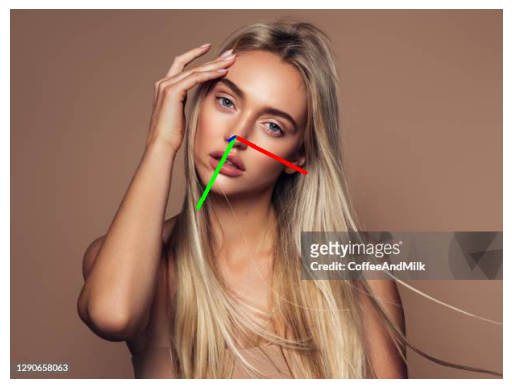

In [26]:
image_path = "/content/Face1.jpg"
image = cv2.imread(image_path)
extracted_landmarks = extract_land(image_path)
pitch = model_pitch_svr.predict(extracted_landmarks)
yaw = model_yaw_svr.predict(extracted_landmarks)
roll = model_roll_svr.predict(extracted_landmarks)
prediction = draw_axis(image,pitch,yaw,roll)
plt.axis('off')
plt.imshow(cv2.cvtColor(prediction, cv2.COLOR_BGR2RGB))


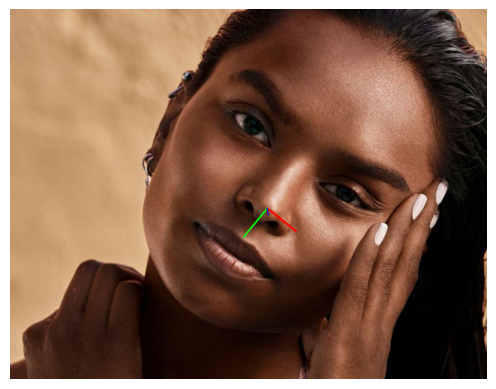

In [27]:
image_path = "/content/Face2.jpg"
image = cv2.imread(image_path)
extracted_landmarks = extract_land(image_path)
pitch = model_pitch_svr.predict(extracted_landmarks)
yaw = model_yaw_svr.predict(extracted_landmarks)
roll = model_roll_svr.predict(extracted_landmarks)
prediction = draw_axis(image,pitch,yaw,roll)
plt.axis('off')
plt.imshow(cv2.cvtColor(prediction, cv2.COLOR_BGR2RGB))

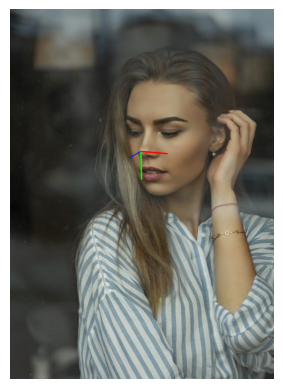

In [28]:
image_path = "/content/Face3.jpg"
image = cv2.imread(image_path)
extracted_landmarks = extract_land(image_path)
pitch = model_pitch_svr.predict(extracted_landmarks)
yaw = model_yaw_svr.predict(extracted_landmarks)
roll = model_roll_svr.predict(extracted_landmarks)
prediction = draw_axis(image,pitch,yaw,roll)
plt.axis('off')
plt.imshow(cv2.cvtColor(prediction, cv2.COLOR_BGR2RGB))

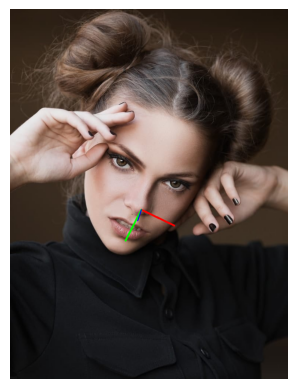

In [29]:
image_path = "/content/Face4.jpg"
image = cv2.imread(image_path)
extracted_landmarks = extract_land(image_path)
pitch = model_pitch_svr.predict(extracted_landmarks)
yaw = model_yaw_svr.predict(extracted_landmarks)
roll = model_roll_svr.predict(extracted_landmarks)
prediction = draw_axis(image,pitch,yaw,roll)
plt.axis('off')
plt.imshow(cv2.cvtColor(prediction, cv2.COLOR_BGR2RGB))

### Testing the Model on Video

In [30]:
# Load the face detection module
import mediapipe
faceModule = mediapipe.solutions.face_mesh

# Load the video
video_path = r'/content/The Intern 2015.mp4'
cap = cv2.VideoCapture(video_path)

# Get video properties
fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Initialize video writer to write output video
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('prediction.mp4', fourcc, fps, (width, height))

# Loop through each frame in the video
while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Convert frame to RGB (as required by MediaPipe)
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Perform face detection and landmark estimation on the frame
    with faceModule.FaceMesh(static_image_mode=False) as faces:
        results = faces.process(frame_rgb)
        if results.multi_face_landmarks:
            # Initialize variables to store face-specific data
            face_nodes_list = []
            nose_landmark_list = []

            for face in results.multi_face_landmarks:
                face_nodes = []
                nose_landmark = results.multi_face_landmarks[0].landmark[4]
                chin_landmark = results.multi_face_landmarks[0].landmark[152]
                face_shape = np.sqrt((nose_landmark.x - chin_landmark.x)**2 + (nose_landmark.y - chin_landmark.y)**2)
                for index, landmark in enumerate(face.landmark):

                    x = (landmark.x - nose_landmark.x) / face_shape
                    y = (landmark.y - nose_landmark.y) / face_shape
                    face_nodes.extend([x, y])

                face_nodes = np.array(face_nodes).reshape(1, -1)
                face_nodes_list.append(face_nodes)
                nose_landmark_list.append(nose_landmark)

            # Predict head pose using SVR models for all faces in the frame
            pitch = model_pitch_svr.predict(np.vstack(face_nodes_list))
            yaw = model_yaw_svr.predict(np.vstack(face_nodes_list))
            roll = model_roll_svr.predict(np.vstack(face_nodes_list))

            frame_with_axis = frame.copy()

            # Draw axis on the frame for all faces
            for i in range(len(face_nodes_list)):
                frame_with_axis = draw_axis(frame_with_axis, pitch[i], yaw[i], roll[i])

            # Write the frame with axis to the output video
            out.write(frame_with_axis)

cap.release()
out.release()
cv2.destroyAllWindows

<function destroyAllWindows>